<a href="https://colab.research.google.com/github/BrianKipngeno/Tweet-classification-project/blob/main/Categorical_tweets_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this project, I will create a classification algorithm that classifies a new tweet to any of the given categories i.e. sports, politics, medical and entertainment.

Dataset link = https://bit.ly/2DysSx7

### Prerequisites

In [1]:
# Importing the standard libraries
# ---
#
import pandas as pd # library for data manipulation
import numpy as np  # library for scientific compuations
import re           # regex library to perform text preprocessing
import string       # library to work with strings
import nltk         # library for natural language processing
import scipy        # library for scientific computing

# Library for Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja
from textblob import TextBlob

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Library for Lemmatization
nltk.download('wordnet')
from textblob import Word

# Library for Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Library for TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=7dccc3d4ada34b26466f2c14645f50f44125189a50690ee75b50585d42918992
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Utility Functions

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Subjectivity
def get_subjectivity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

### Step 1: Data exploration

In [3]:
# Loading our dataset

df = pd.read_excel('https://bit.ly/2DysSx7')
df.columns = ['text', 'target']
df.head()

,text,target
0,@ACNI2012 @TheToka920 Never knew having 1 or 2...,sports
1,"MYCA Magical Moments:\n\nSeptember, 2011: Sham...",sports
2,The current state of last year's @BBL finalist...,sports
3,@HOLLYJISOO Why did you bring a cricket...,sports
4,Babar Azam only Pakistani included in the ICC ...,sports


In [4]:
# We can determine the size of our dataset
# ---
#
df.shape

(1162, 2)

In [5]:
# To get an understanding of our dataset lets sample 10 records
# ---
#
df.sample(5)

,text,target
1050,RT @Tennis: Tennis Australia said last night's...,sports
881,RT @ImmoralishMe: I remembered this from Novem...,politics
435,RT @YssHeadOffice_: @ANI H.H Sant Shri Asharam...,medical
158,RT @grangershug: this movie is literally art i...,entertainment
768,RT @shaneharris: NEW: Ukraine prosecutor offer...,politics


In [6]:
# Because this dataset is abit large, we will consider working with
# random sample of 200 records. This is for demo purposes because
# a large dataset would take a long time to perform some text
# processing techniques.
# ---
#
sample_df = df.sample(200)

This dataset will need some data cleaning i.e. removal of links, hashtags, etc

In [9]:
import seaborn as sns

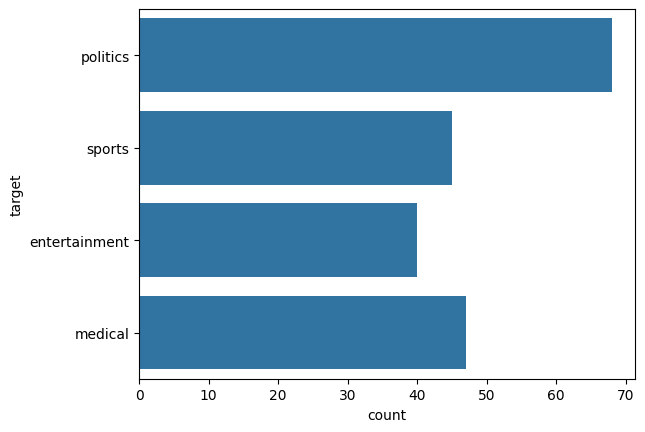

In [10]:
# Plotting the distribution of target
# ---
#
sns.countplot(sample_df['target']);

We have an unbalanced dataset. Let's create a balanced one

In [11]:
# sampling tweets with medical class
df_medical = df[df["target"] == 'medical']
df_medical = df_medical.sample(50)

# sampling tweets with entertainment class
df_entertainment = df[df["target"] == 'entertainment']
df_entertainment = df_entertainment.sample(50)

# sampling tweets politics class
df_politics = df[df["target"] == 'politics']
df_politics = df_politics.sample(50)

# sampling tweets sports
df_sports = df[df["target"] == 'sports']
df_sports = df_sports.sample(50)


# combining our dataframes
df = pd.concat([df_medical, df_entertainment, df_politics, df_sports])
df.head()

,text,target
686,@mints0rbet @J3fr94 I wonder who deserves a me...,medical
587,RT @pinkk9lover: Where was your fake outrage @...,medical
445,RT @footballitalia: Olivier Giroud ought to ha...,medical
481,Why do we need immigrants? 👇 People like Jonny...,medical
416,RT @CY_ELS: The Patient in Free Movement Law: ...,medical


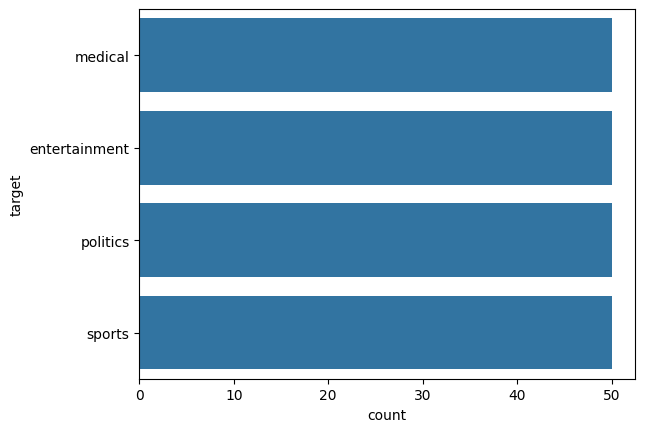

In [12]:
# Previewing the distribution of target
# ---
#
sns.countplot(df['target']);

We now have a balanced dataset.

### Data preparation

#### Basic data cleaning

In [13]:
# Let's determine whether our columns have the right data types
# ---
#
df.dtypes

,0
text,object
target,object


In [14]:
# What values are in our target variable?
# ---
#
df.target.unique()

array(['medical', 'entertainment', 'politics', 'sports'], dtype=object)

In [15]:
# Let's check for missing values
# ---
#
df.isnull().sum()

,0
text,0
target,0


We don't have any missing values, so we are good to go.

#### Text processing

In [16]:
# We will create a custom function that will contain all the text cleaning
# techniques. We will then reuse the same function for cleaning new data.
# ---
#
def text_cleaning(text):
  # Removing url/links
  df['text'] = df.text.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+','', str(x)))

  # Removing @ and # characters and replacing them with space
  df['text'] = df.text.str.replace('#',' ')
  df['text'] = df.text.str.replace('@',' ')

  # Conversion to lowercase
  df['text'] = df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing punctuation characters
  df['text'] = df.text.str.replace('[^\w\s]','')

  # Removing stop words
  df['text'] = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # Lemmatization
  df['text'] = df.text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [17]:
# Applying the text_cleaning function to our dataframe.
# ---
# NB: This process may take 2-5 min.
# ---
#
df.text.apply(text_cleaning)
df.sample(5)

,text,target
310,rt bbhcheol: mingyu told crowd put phone every...,entertainment
843,rt elfloyo: im2byteme realdonaldtrump un potus...,politics
543,rt drharjitbhatti: white coat march caa-nrc-np...,medical
1050,rt tennis: tennis australia said last night's ...,sports
771,rt skinnerpm: glad see new york time covering ...,politics


#### Feature engineering

In [18]:
# We will create a custom function that will contain all the
# feature engineering techniques. We can then use the function for cleaning new data.
# ---
#
def feature_engineering(text):
  # Length of text
  df['length_of_text'] = df.text.str.len()

  # Word count
  df['word_count'] = df.text.apply(lambda x: len(str(x).split(" ")))

  # Word density (Average no. of words / text)
  df['avg_word_length'] = df.text.apply(lambda x: avg_word(x))

  # Noun Count
  df['noun_count'] = df.text.apply(lambda x: pos_check(x, 'noun'))

  # Verb Count
  df['verb_count'] = df.text.apply(lambda x: pos_check(x, 'verb'))

  # Adjective Count / Text
  df['adj_count'] = df.text.apply(lambda x: pos_check(x, 'adj'))

  # Adverb Count / Text
  df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

  # Pronoun
  df['pron_count'] = df.text.apply(lambda x: pos_check(x, 'pron'))

  # Subjectivity
  df['subjectivity'] = df.text.apply(get_subjectivity)

  # Polarity
  df['polarity'] = df.text.apply(get_polarity)

In [19]:
# Applying the custom feature engineering function to our dataframe.
# This process may take 2-5 min.
# ---
#
df.text.apply(feature_engineering)
df.sample(5)

,text,target,length_of_text,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
131,rt itgdsports: indvsaus | rishabh pant suffere...,sports,102,15,5.866667,9,4,2,0,0,0.0,0.0
877,rt abcpolitics: bernie sander build momentum p...,politics,81,11,6.454545,8,0,2,1,0,0.0,0.0
61,rt aaliaaaliya: wasim khan best thing happened...,sports,105,16,5.625000,10,2,2,2,0,0.0,0.0
103,"gabino_iglesias pankmagazine ah, gabino-sama. ...",sports,77,9,7.666667,6,1,0,1,0,0.0,0.0
1099,last time picked phone talk someone? instead m...,sports,78,11,6.181818,8,2,1,1,0,0.0,0.0


In [20]:
# Performing further feature engineering techniques
# ---
#

# Feature Construction: Word Level N-Gram TF-IDF Feature
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,3),  stop_words= 'english')
df_word_vect = tfidf.fit_transform(df.text)

# Feature Construction: Character Level N-Gram TF-IDF
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char', ngram_range=(1,3),  stop_words= 'english')
df_char_vect = tfidf.fit_transform(df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [21]:
# Label Preparation i.e. replacing categorial values with numerical ones
# ---
#
y = np.array(df['target'].replace(['politics', 'sports', 'medical', 'entertainment'], ['0', '1', '2', '3']))
y

array(['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3',
       '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3',
       '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3',
       '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3',
       '3', '3', '3', '3', '3', '3', '3', '3', '3', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1

In [22]:
# Let's prepare the constructed features for modeling
# ---
# We will select all columns but the sentiment (which is the label) and text columns
# ---
#
X_metadata = np.array(df[df.columns.difference(['target', 'text'])])
X_metadata

array([[ 1.        ,  1.        ,  7.14285714, ...,  0.        ,
         1.        ,  7.        ],
       [ 2.        ,  0.        ,  6.92307692, ...,  0.        ,
         1.        , 13.        ],
       [ 2.        ,  0.        ,  6.26666667, ...,  0.        ,
         2.        , 15.        ],
       ...,
       [ 0.        ,  0.        ,  8.33333333, ...,  0.        ,
         0.        ,  3.        ],
       [ 1.        ,  1.        ,  6.18181818, ...,  0.        ,
         2.        , 11.        ],
       [ 3.        ,  1.        ,  4.95238095, ...,  0.        ,
         1.        , 21.        ]])

In [23]:
# We combine our two tfidf (sparse) matrices and X_metadata
# ---
#
X = scipy.sparse.hstack([df_word_vect, df_char_vect, X_metadata])
X

<200x2010 sparse matrix of type '<class 'numpy.float64'>'
	with 28859 stored elements in COOrdinate format>

### Step 3: Data modelling

In [24]:
# Splitting our data
# ---
#
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Fitting our model
# ---
#

# Importing the algorithms
# ---
#
from sklearn.linear_model import LogisticRegression      # Logistic Regression Classifier
from sklearn.tree import DecisionTreeClassifier          # Decision Tree Classifier
from sklearn.svm import SVC                              # SVM Classifier
from sklearn.naive_bayes import MultinomialNB            # Naive Bayes Classifier
from sklearn.neighbors import KNeighborsClassifier       # KNN Classifier

# Ensemble classifiers
from sklearn.ensemble import BaggingClassifier           # Bagging Meta-Estimator Classifier
from sklearn.ensemble import RandomForestClassifier      # RandomForest Classifier
from sklearn.ensemble import AdaBoostClassifier          # AdaBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier  # AdaBoost GradientBoostingClassifier


# Instantiating our models
# ---
#
logistic_classifier = LogisticRegression(solver='saga', max_iter=800, multi_class='multinomial') # solver works well with a large dataset like ours
decision_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
naive_classifier = MultinomialNB()

bagging_meta_classifier = BaggingClassifier()
random_forest_classifier = RandomForestClassifier()
ada_boost_classifier = AdaBoostClassifier(random_state=42)
gbm_classifier = GradientBoostingClassifier(random_state=42)

# Training our models
# ---
#
logistic_classifier.fit(X_train, y_train)
decision_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
naive_classifier.fit(X_train, y_train)

bagging_meta_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)
ada_boost_classifier.fit(X_train, y_train)
gbm_classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GradientBoostingClassifier(random_state=42)

In [26]:
# Making predictions
# ---
#
logistic_y_prediction = logistic_classifier.predict(X_test)
decision_y_prediction = decision_classifier.predict(X_test)
svm_y_prediction = svm_classifier.predict(X_test)
knn_y_prediction = knn_classifier.predict(X_test)
naive_y_prediction = naive_classifier.predict(X_test)

bagging_y_classifier = bagging_meta_classifier.predict(X_test)
random_forest_y_classifier = random_forest_classifier.predict(X_test)
ada_boost_y_classifier = ada_boost_classifier.predict(X_test)
gbm_y_classifier = gbm_classifier.predict(X_test)

In [27]:
# Evaluating the Models
# ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Accuracy scores
#
print("Logistic Regression Classifier", accuracy_score(logistic_y_prediction, y_test))
print("Decision Trees Classifier", accuracy_score(decision_y_prediction, y_test))
print("SVN Classifier", accuracy_score(svm_y_prediction, y_test))
print("KNN Classifier", accuracy_score(knn_y_prediction, y_test))
print("Naive Bayes Classifier", accuracy_score(naive_y_prediction, y_test))

print("Bagging Classifier", accuracy_score(bagging_y_classifier, y_test))
print("Random Forest Classifier", accuracy_score(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", accuracy_score(ada_boost_y_classifier, y_test))
print("GBM Classifier", accuracy_score(gbm_y_classifier, y_test))

Logistic Regression Classifier 0.4
Decision Trees Classifier 0.375
SVN Classifier 0.15
KNN Classifier 0.175
Naive Bayes Classifier 0.175
Bagging Classifier 0.575
Random Forest Classifier 0.7
Ada Boost Classifier 0.525
GBM Classifier 0.625


We could use accuracy as a reliable metric because our dataset was balanced.

In [28]:
# Confusion matrix
# ---
# Regardless of the size of the confusion matrix, the method for intepretation is the same.
# The left-hand side contains the predicted values and the actual class labels run across the top.
# The instances that the classifier has correctly predicted run diagonally from the top-left
# to the bottom-right.
# ---
#
print('Logistic Regression Classifier:')
print(confusion_matrix(logistic_y_prediction, y_test))

print('Decision Trees Classifier:')
print(confusion_matrix(decision_y_prediction, y_test))

print('SVN Classifier:')
print(confusion_matrix(svm_y_prediction, y_test))

print('KNN Classifier:')
print(confusion_matrix(knn_y_prediction, y_test))

print('Naive Bayes Classifier:')
print(confusion_matrix(naive_y_prediction, y_test))

print('Bagging Classifier:')
print(confusion_matrix(bagging_y_classifier, y_test))

print('Random Forest Classifier:')
print(confusion_matrix(random_forest_y_classifier, y_test))

print('Ada Boost Classifier:')
print(confusion_matrix(ada_boost_y_classifier, y_test))

print('GBM Classifier:')
print(confusion_matrix(gbm_y_classifier, y_test))

Logistic Regression Classifier:
[[3 2 1 4]
 [1 5 1 5]
 [4 1 4 2]
 [1 2 0 4]]
Decision Trees Classifier:
[[1 0 1 6]
 [2 6 0 3]
 [2 3 5 3]
 [4 1 0 3]]
SVN Classifier:
[[ 1  1  2  3]
 [ 1  1  0  1]
 [ 7  8  4 11]
 [ 0  0  0  0]]
KNN Classifier:
[[3 3 4 4]
 [1 2 1 4]
 [2 1 0 5]
 [3 4 1 2]]
Naive Bayes Classifier:
[[ 0  0  0  0]
 [ 0  1  0  0]
 [ 9  9  6 15]
 [ 0  0  0  0]]
Bagging Classifier:
[[6 4 1 4]
 [1 4 0 3]
 [0 1 5 0]
 [2 1 0 8]]
Random Forest Classifier:
[[7 1 1 5]
 [0 8 0 2]
 [1 0 5 0]
 [1 1 0 8]]
Ada Boost Classifier:
[[ 7  2  1 10]
 [ 1  5  0  0]
 [ 0  0  5  1]
 [ 1  3  0  4]]
GBM Classifier:
[[5 1 1 4]
 [2 6 0 1]
 [2 2 5 1]
 [0 1 0 9]]


In [29]:
# Classification Reports
# ---
#
print("Logistic Regression Classifier", classification_report(logistic_y_prediction, y_test))
print("Decision Trees Classifier", classification_report(decision_y_prediction, y_test))
print("SVM Classifier", classification_report(svm_y_prediction, y_test))
print("KNN Classifier", classification_report(knn_y_prediction, y_test))
print("Naive Bayes Classifier", classification_report(naive_y_prediction, y_test))

print("Bagging Classifier", classification_report(bagging_y_classifier, y_test))
print("Random Forest Classifier", classification_report(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", classification_report(ada_boost_y_classifier, y_test))
print("GBM Classifier", classification_report(gbm_y_classifier, y_test))

Logistic Regression Classifier               precision    recall  f1-score   support

           0       0.33      0.30      0.32        10
           1       0.50      0.42      0.45        12
           2       0.67      0.36      0.47        11
           3       0.27      0.57      0.36         7

    accuracy                           0.40        40
   macro avg       0.44      0.41      0.40        40
weighted avg       0.46      0.40      0.41        40

Decision Trees Classifier               precision    recall  f1-score   support

           0       0.11      0.12      0.12         8
           1       0.60      0.55      0.57        11
           2       0.83      0.38      0.53        13
           3       0.20      0.38      0.26         8

    accuracy                           0.38        40
   macro avg       0.44      0.36      0.37        40
weighted avg       0.50      0.38      0.40        40

SVM Classifier               precision    recall  f1-score   support

   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: Undefin

Evaluation our Models

- Accuracy: the percentage of texts that were assigned the correct topic.
- Precision: the percentage of texts the classifier classified correctly out of the total number of texts it predicted for each topic
- Recall: the percentage of texts the model predicted for each topic out of the total number of texts it should have predicted for that topic.
- F1 Score: the average of both precision and recall.